# PyTorch mutual information neural estimation tests

Trivial tests with multivariate Gaussian and uniform distribution

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchfd
import mutinfo

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda:0
Devices count: 2


In [5]:
from tqdm import tqdm, trange

In [6]:
from mutinfo.distributions.base import *
from mutinfo.distributions.tools import mapped_multi_rv_frozen

In [7]:
from misc.modules import *
from misc.utils import *
from misc.plots import *

## Dataset

Experimental setup

In [8]:
mutual_information = 10.0
dimensionality = 2

degrees_of_freedom = 2 # For Student's distribution
randomize_interactions = False
shuffle_interactions = True

random_variable = CorrelatedUniform(
    mutual_information,
    dimensionality,
    randomize_interactions=randomize_interactions,
    shuffle_interactions=shuffle_interactions
)

In [9]:
n_samples = 10000

In [10]:
import math

math.log(10000)

9.210340371976184

## Estimating MI

Dataset and dataloader

In [11]:
x, y = random_variable.rvs(n_samples)
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32),
    torch.tensor(y, dtype=torch.float32)
)

x, y = random_variable.rvs(n_samples)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32),
    torch.tensor(y, dtype=torch.float32)
)

In [12]:
batch_size = 512

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [15]:
class DenseT(torchfd.mutual_information.MINE):
    def __init__(self, X_dim: int, Y_dim: int, inner_dim: int=256) -> None:
        super().__init__(marginalizer=torchfd.mutual_information.OuterProductMarginalizer())

        self.model = torch.nn.Sequential(
            torch.nn.Linear(X_dim + Y_dim, inner_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(inner_dim, inner_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(inner_dim, 1)
        )        

    @torchfd.mutual_information.MINE.marginalized
    def forward(self, x: torch.tensor, y: torch.tensor) -> torch.tensor:
        return self.model(torch.cat((x, y), dim=1))

Model

In [16]:
config = {}

config["discriminator_network"] = "DenseT"
config["discriminator_network_inner_dim"] = 256
config["discriminator_network_output_dim"] = 256

model = DenseT(dimensionality, dimensionality).to(device)

Loss

In [17]:
# Loss.
biased = False
ema_multiplier = 1.0e-2
marginalize = "permute" # "permute", "product"

losses = {
    "DonskerVaradhan": torchfd.loss.DonskerVaradhanLoss(biased=biased, ema_multiplier=ema_multiplier),
    "NWJ": torchfd.loss.NWJLoss(),
    "Nishiyama": torchfd.loss.NishiyamaLoss(),
    "InfoNCE": torchfd.loss.InfoNCELoss(),
}

loss_name = "InfoNCE"
loss = losses[loss_name]

Optimizer

In [18]:
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training

In [19]:
import matplotlib
from matplotlib import pyplot as plt

In [20]:
# Number of epochs used to average the estimate.
average_epochs = 100

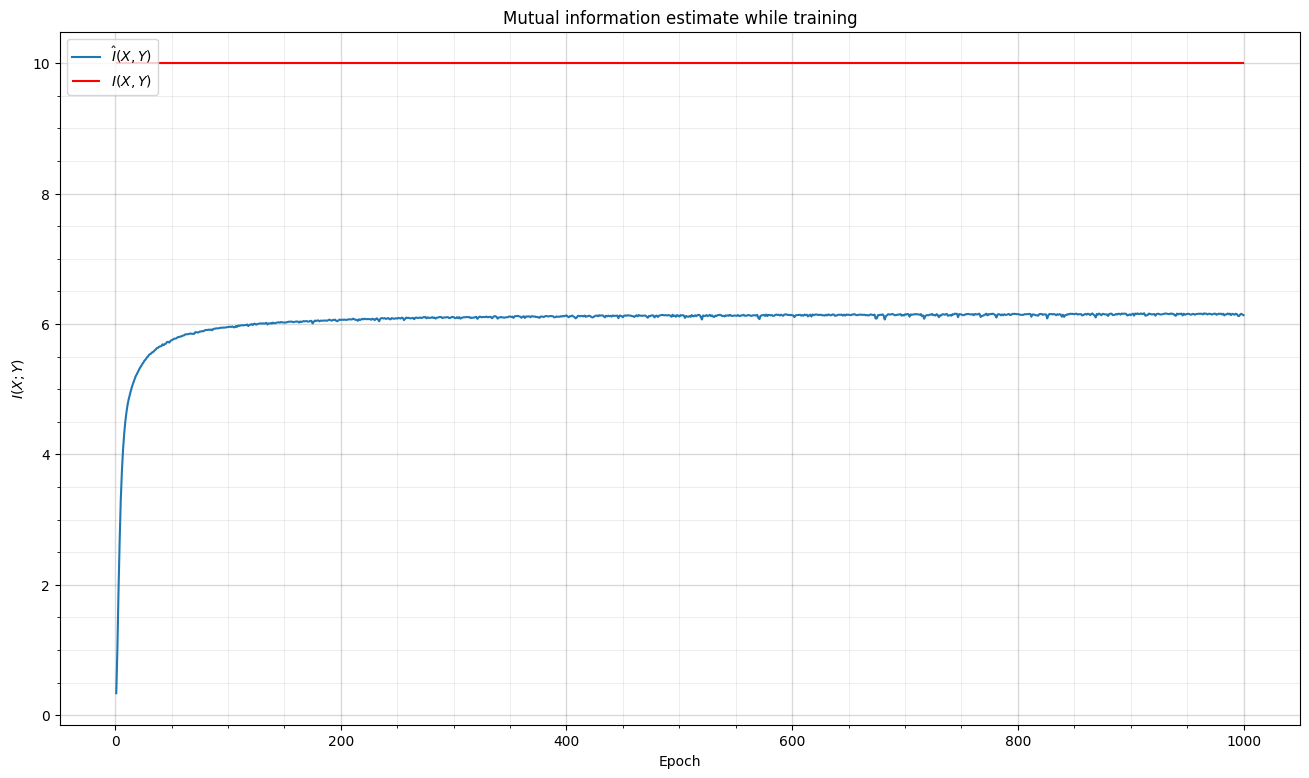

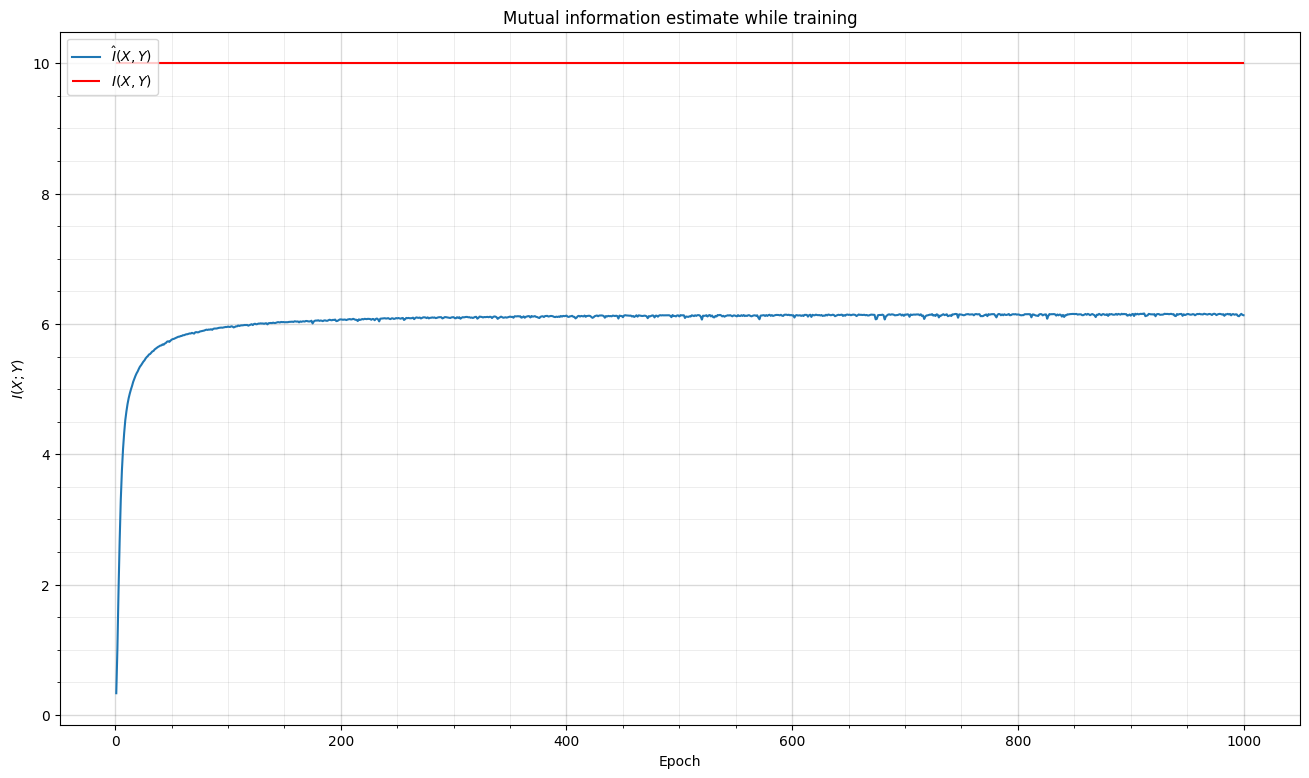

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:25<00:00,  1.24it/s]

Current estimate: 6.13
Running median: 6.15


In [21]:
from collections import defaultdict
from IPython.display import clear_output
from tqdm import trange

n_epochs = 1000

history = defaultdict(list)
for epoch in trange(1, n_epochs + 1, mininterval=1):    
    # Training.
    
    for index, batch in enumerate(train_dataloader):
        x, y = batch
        batch_size = x.shape[0]
        
        optimizer.zero_grad()

        _loss = loss(*model(x.to(device), y.to(device)))
        _loss.backward()
        
        optimizer.step()
        
    history["train_mutual_information"].append(model.get_mutual_information(train_dataloader, loss, device))
    history["test_mutual_information"].append(model.get_mutual_information(test_dataloader, loss, device))

    if epoch % 10 == 0:
        clear_output(wait=True)
        plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), history["train_mutual_information"])
        plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), history["test_mutual_information"])
        print(f"Current estimate: {history['test_mutual_information'][-1]:.2f}")
        print(f"Running median: {np.median(history['test_mutual_information'][-average_epochs:]):.2f}")

In [ ]:
print(f"Current estimate: {history['test_mutual_information'][-1]:.2f}")